## 用N-Gram模型在莎士比亚文集中训练word embedding
N-gram 是计算机语言学和概率论范畴内的概念，是指给定的一段文本中N个项目的序列。
N=1 时 N-gram 又称为 unigram，N=2 称为 bigram，N=3 称为 trigram，以此类推。实际应用通常采用 bigram 和 trigram 进行计算。
本示例在莎士比亚文集上实现了trigram。

# 环境
本教程基于paddle2.0-alpha编写，如果您的环境不是本版本，请先安装paddle2.0-alpha。

In [189]:
import paddle
paddle.__version__

'2.0.0-alpha0'

## 数据集&&相关参数
训练数据集采用了莎士比亚文集，[下载](https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt)，保存为txt格式即可。<br>
context_size设为2，意味着是trigram。embedding_dim设为256。

In [190]:
embedding_dim = 256
context_size = 2

In [191]:
# 文件路径
path_to_file = './shakespeare.txt'
test_sentence = open(path_to_file, 'rb').read().decode(encoding='utf-8')

# 文本长度是指文本中的字符个数
print ('Length of text: {} characters'.format(len(test_sentence)))

Length of text: 1115394 characters


## 去除标点符号
用`string`库中的punctuation，完成英文符号的替换。

In [192]:
from string import punctuation
process_dicts={i:'' for i in punctuation}
print(process_dicts)

{'!': '', '"': '', '#': '', '$': '', '%': '', '&': '', "'": '', '(': '', ')': '', '*': '', '+': '', ',': '', '-': '', '.': '', '/': '', ':': '', ';': '', '<': '', '=': '', '>': '', '?': '', '@': '', '[': '', '\\': '', ']': '', '^': '', '_': '', '`': '', '{': '', '|': '', '}': '', '~': ''}


In [193]:
punc_table = str.maketrans(dicts)
test_sentence = test_sentence.translate(punc_table)
test_sentence = test_sentence.lower().split()
vocab = set(test_sentence)
print(len(vocab))

12848


## 数据预处理
将文本被拆成了元组的形式，格式为(('第一个词', '第二个词'), '第三个词');其中，第三个词就是我们的目标。

In [194]:
trigram = [[[test_sentence[i], test_sentence[i + 1]], test_sentence[i + 2]]
           for i in range(len(test_sentence) - 2)]

word_to_idx = {word: i for i, word in enumerate(vocab)}
idx_to_word = {word_to_idx[word]: word for word in word_to_idx}
# 看一下数据集
print(trigram[:3])

[[['first', 'citizen'], 'before'], [['citizen', 'before'], 'we'], [['before', 'we'], 'proceed']]


## 构建`Dataset`类 加载数据
用`paddle.io.Dataset`构建数据集，然后作为参数传入到`paddle.io.DataLoader`，完成数据集的加载。

In [184]:
import paddle
batch_size = 256
paddle.enable_imperative()
class TrainDataset(paddle.io.Dataset):
    def __init__(self, tuple_data):
        self.tuple_data = tuple_data

    def __getitem__(self, idx):
        data = self.tuple_data[idx][0]
        label = self.tuple_data[idx][1]
        data = list(map(lambda w: word_to_idx[w], data))
        label = word_to_idx[label]
        
        return data, label
    
    def __len__(self):
        return len(self.tuple_data)
    
train_dataset = TrainDataset(trigram)
train_loader = paddle.io.DataLoader(train_dataset, places=paddle.fluid.cpu_places(), return_list=True,\
                                    shuffle=True, batch_size=batch_size, drop_last=True)

## 组网&训练
这里用paddle动态图的方式组网。为了构建Trigram模型，用一层 `Embedding` 与两层 `Linear` 完成构建。`Embedding` 层对输入的前两个单词embedding，然后输入到后面的两个`Linear`层中，完成特征提取。

In [185]:
import paddle
import numpy as np
class NGramModel(paddle.nn.Layer):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramModel, self).__init__()
        self.embedding = paddle.nn.Embedding(size=[vocab_size, embedding_dim])
        self.linear1 = paddle.nn.Linear(context_size * embedding_dim, 1024)
        self.linear2 = paddle.nn.Linear(1024, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x = paddle.reshape(x, [-1, context_size * embedding_dim])
        x = self.linear1(x)
        x = paddle.nn.functional.relu(x)
        x = self.linear2(x)
        x = paddle.nn.functional.softmax(x)
        return x

### 定义`train()`函数，对模型进行训练。

In [195]:
vocab_size = len(vocab)
epochs = 5
losses = []
def train(model):
    model.train()
    optim = paddle.optimizer.Adam(learning_rate=0.01, parameter_list=model.parameters())
    for epoch in range(epochs):
        for batch_id, data in enumerate(train_loader()):
            x_data = data[0]
            y_data = data[1]
            predicts = model(x_data)
            loss = paddle.nn.functional.cross_entropy(predicts, y_data)
            avg_loss = paddle.mean(loss)
            avg_loss.backward()
            if batch_id % 100 == 0:
                losses.append(avg_loss.numpy())
                print("epoch: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, avg_loss.numpy()))
            optim.minimize(avg_loss)
            model.clear_gradients()
model = NGramModel(vocab_size, embedding_dim, context_size)
train(model)

epoch: 0, batch_id: 0, loss is: [9.4609375]
epoch: 0, batch_id: 100, loss is: [6.8079987]
epoch: 0, batch_id: 200, loss is: [7.15846]
epoch: 0, batch_id: 300, loss is: [6.536172]
epoch: 0, batch_id: 400, loss is: [6.847218]
epoch: 0, batch_id: 500, loss is: [6.6856213]
epoch: 0, batch_id: 600, loss is: [7.023284]
epoch: 0, batch_id: 700, loss is: [6.668572]
epoch: 1, batch_id: 0, loss is: [6.251506]
epoch: 1, batch_id: 100, loss is: [6.3487673]
epoch: 1, batch_id: 200, loss is: [6.3545203]
epoch: 1, batch_id: 300, loss is: [6.2171617]
epoch: 1, batch_id: 400, loss is: [6.0640473]
epoch: 1, batch_id: 500, loss is: [6.469482]
epoch: 1, batch_id: 600, loss is: [6.342491]
epoch: 1, batch_id: 700, loss is: [6.3045797]
epoch: 2, batch_id: 0, loss is: [5.993376]
epoch: 2, batch_id: 100, loss is: [5.8828726]
epoch: 2, batch_id: 200, loss is: [5.9760466]
epoch: 2, batch_id: 300, loss is: [5.756211]
epoch: 2, batch_id: 400, loss is: [6.112233]
epoch: 2, batch_id: 500, loss is: [5.8354917]
epoch:

## 打印loss下降曲线
通过可视化loss的曲线，可以看到模型训练的效果。

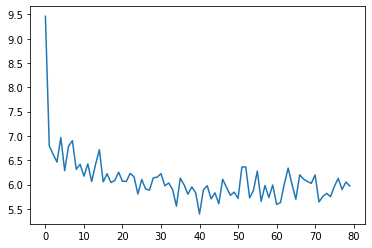

In [187]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(losses)

## 预测
用训练好的模型进行预测。

In [188]:
import random
def test(model):
    model.eval()
    # 从最后10组数据中随机选取1个
    idx = random.randint(len(trigram)-10, len(trigram)-1)
    print('the input words is: ' + trigram[idx][0][0] + ', ' + trigram[idx][0][1])
    x_data = list(map(lambda w: word_to_idx[w], trigram[idx][0]))
    x_data = paddle.imperative.to_variable(np.array(x_data))
    predicts = model(x_data)
    predicts = predicts.numpy().tolist()[0]
    predicts = predicts.index(max(predicts))
    print('the predict words is: ' + idx_to_word[predicts])
    y_data = trigram[idx][1]
    print('the true words is: ' + y_data)
test(model)

the input words is: whiles, thou
the predict words is: art
the true words is: art
